In [7]:
from pymongo  import MongoClient
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection
#! pip install scikit-surprise
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Chargement des données AVIS

In [8]:
# Pour lancer le demon de la base de données mongod
# source ~/.bash_profile 
# mongod --config ~/db/mongod.cfg 
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC_01"] 
collection = db["avis"]

In [9]:
df_avis = pd.DataFrame(list(collection.find())).loc[:,["author","title","note","date_published"]]
df_avis.head(5)

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


In [10]:
num_utilisateurs  = df_avis["author"].nunique()
num_jeux  = df_avis["title"].nunique()

print(f"Il y a {num_utilisateurs} utilisateurs et {num_jeux} jeux dans la base.")
print("Taile de la base:\n  ",len(df_avis))

Il y a 13623 utilisateurs et 10709 jeux dans la base.
Taile de la base:
   246524


## Stastistique sur les utilisateurs ayant noté plusieurs fois un jeu.

In [11]:
df_avis_unique = df_avis.groupby(['author','title']).value_counts()
df_avis_unique.head(10)

author            title                                note  date_published     
#yuyu#            Bubblee Pop                          8.5   2019-01-19 23:11:33    2
                  KARMAKA                              8.8   2018-02-25 09:01:19    2
$hadow            Le Dilemme du Roi                    9.0   2021-01-03 21:14:16    5
$lebat@$          Deluxe Camping                       10.0  2007-11-06 12:28:47    1
&lo               Sporz Original Outbreak              10.0  2011-01-18 12:28:59    1
*FitzChevalerie*  7 Wonders - Extension "Cities"       8.0   2012-11-20 13:36:22    1
                  7 Wonders - Extension "Wonder Pack"  7.4   2013-10-14 20:35:59    1
                  A Few Acres of Snow                  10.0  2012-05-23 12:29:05    1
                  Archipelago                          10.0  2012-10-16 13:36:22    1
                  Archipelago : Solo Expansion         10.0  2012-12-06 18:14:14    1
dtype: int64

Nous observons qu'il y'a des duplications de mêmes lignes.

## Suppression des duplications

In [12]:
df_avis = df_avis.drop_duplicates(subset=['author','title','note','date_published'])
df_avis.head()

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


## Pour chaque couple utilisateur, jeu on récupère la liste des notes avec la date

In [13]:
# Regroupement par auteur et titre, et création de la liste de tuples pour chaque cas
df_notes = df_avis.groupby(['author', 'title']).apply(lambda x: list(zip(x['note'], x['date_published'])))
notes = df_notes[df_notes.apply(len) >= 2]
notes_dict = notes.to_dict()
notes

author        title                                       
Actorios      Footmania                                       [(6.0, 2006-06-03 12:28:42), (8.0, 2004-09-11 ...
Belboudin     Poker                                           [(5.0, 2014-11-11 17:31:27), (5.5, 2015-10-02 ...
Benjyskahn    Les Colons de Catane : Politique & Intrigues    [(9.0, 2021-06-05 11:51:39), (6.0, 2021-06-05 ...
Biff          Alcatraz                                        [(8.0, 2009-02-08 12:28:52), (8.0, 2006-08-13 ...
Clem_Achille  Trivial Pursuit - Star Wars                     [(8.0, 2010-12-19 12:28:59), (6.0, 2010-12-18 ...
                                                                                    ...                        
thespios      Poker                                           [(9.0, 2021-11-22 22:24:22), (8.0, 2021-09-17 ...
winforlife    Gangster                                        [(8.0, 2008-01-05 12:28:48), (4.0, 2007-06-18 ...
yahndrev      Merlin                         

In [14]:
authors_notes = list(set(notes.index.get_level_values('author')))
titles_notes = list(set(notes.index.get_level_values('title')))

In [15]:
print(f"Il y'a {len(notes)} notes qui ont été renoté au moins une deuxième fois correspondant à {100*len(notes)/len(df_avis)} % des notes")
print(f"Il y'a {len(authors_notes)} utilisateurs qui ont renoté au moins une deuxième fois au moins un jeu corresspondant à {100*len(authors_notes)/num_utilisateurs} % des utilisateurs")
print(f"Il y'a {len(titles_notes)} jeux qui ont été renoté au moins une deuxième fois correspondants à {100*len(titles_notes)/num_jeux} % des jeux")

Il y'a 111 notes qui ont été renoté au moins une deuxième fois correspondant à 0.0630030309566244 % des notes
Il y'a 81 utilisateurs qui ont renoté au moins une deuxième fois au moins un jeu corresspondant à 0.5945826910372165 % des utilisateurs
Il y'a 65 jeux qui ont été renoté au moins une deuxième fois correspondants à 0.6069661032776169 % des jeux


In [16]:
# Trier les sous-listes de notes_dict par date
for key, value in notes_dict.items():
  notes_dict[key] = sorted(value, key=lambda x: x[1])

### Ecriture des renotes dans un fichier
Juste pour voir comment les utilisateurs changent leurs notations

In [17]:
import json

# Conversion des tuples en chaînes de caractères
notes_dict_str = {}
for (author,title ), value in notes_dict.items():
  new_key = str(author) + " ::&:: " + str(title) 
  notes_dict_str[new_key] = value

# Nom du fichier dans lequel écrire le dictionnaire
filename = 'notes_renotees.json'

# Écriture du dictionnaire dans le fichier en format JSON
with open(filename, 'w') as f:
    json.dump(notes_dict_str, f)

# Affichage d'un message confirmant l'écriture du fichier
print(f"Le dictionnaire a été écrit dans le fichier {filename} en format JSON.")


Le dictionnaire a été écrit dans le fichier notes_renotees.json en format JSON.


### Les utilisateurs qui améliorent leurs notes vs ceux qui détériorent les leurs

41 améliorent leurs notes vs 28 détériorent leurs notes vs 42 ont remis la même note


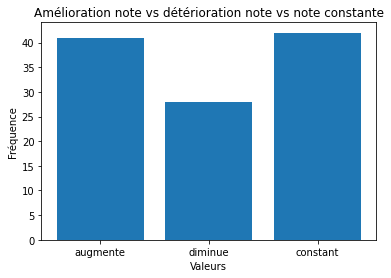

In [18]:
import matplotlib.pyplot as plt

count_plus = 0
count_moins = 0
count_const = 0

# Parcours de chaque sous-liste
for key, value in notes_dict.items():
  croissant = True
  for i in range(1, len(value)):
    if value[i][0] <= value[i-1][0]:
      croissant = False
      break
  if croissant:
      count_plus += 1
  
  decroissant = True
  for i in range(1, len(value)):
    if value[i][0] >= value[i-1][0]:
      decroissant = False
      break
  if decroissant:
      count_moins += 1
  
  constant = True
  for i in range(1, len(value)):
    if value[i][0] != value[i-1][0]:
      constant = False
      break
  if constant:
      count_const += 1

print(f"{count_plus} améliorent leurs notes vs {count_moins} détériorent leurs notes vs {count_const} ont remis la même note")
# Création du diagramme à barres
plt.bar(['augmente','diminue','constant'], [count_plus,count_moins,count_const])

# Ajout de la légende et du titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Amélioration note vs détérioration note vs note constante')

# Affichage du diagramme
plt.show()


Ce résultat nous offrent plusieurs chemins potentiels à explorer:
- garder la première note
- garder la dernière note (meilleur choix à mon sens)
- garder la note maximale
- garder la note minimale
- garder la note moyenne
- tout garder
- ne rien garder (pourquoi pas)
- pour ceux qui ont remis la note ?

# Garder la dernière note

In [19]:
print(len(df_avis))
# Convertir la colonne 'date_published' en type de données datetime
df_avis['date_published'] = pd.to_datetime(df_avis['date_published'])

# Trier le DataFrame par 'author', 'title' et 'date_published'
df_avis = df_avis.sort_values(['author', 'title', 'date_published'])

# Grouper par 'author' et 'title' et prendre la dernière 'date_published' et la note correspondante
df_avis = df_avis.groupby(['author', 'title']).agg({'note': 'last', 'date_published': 'last'}).reset_index()

len(df_avis)

176182


176071

In [20]:
df_avis.head()

,author,title,note,date_published
0,#yuyu#,Bubblee Pop,8.5,2019-01-19 23:11:33
1,#yuyu#,KARMAKA,8.8,2018-02-25 09:01:19
2,$hadow,Le Dilemme du Roi,9.0,2021-01-03 21:14:16
3,$lebat@$,Deluxe Camping,10.0,2007-11-06 12:28:47
4,&lo,Sporz Original Outbreak,10.0,2011-01-18 12:28:59


## 1. Statistiques sur le nombre d'utilisateurs en fonction du nombre minimum de notes

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

l_min = [0,5,10,20,30,50,100,200,300]
n_authors = []
n_titles = []
tailles_df = []

df_avis = df_avis[['author','title','note']]
authors_counts = df_avis['author'].value_counts()
for min_note in l_min:
  authors = authors_counts[authors_counts >= min_note].index.to_list()
  n_authors.append(np.unique(authors).shape[0])
  
  df_avis_k = df_avis[df_avis['author'].isin(authors)]
  n_titles.append(df_avis_k["title"].nunique())
  tailles_df.append(len(df_avis_k))

print("Nombre minimums de notes requis:\n  ",l_min)
print("Liste du nombre d'authors restants:\n  ",n_authors)
print("Liste du nombre de jeux restants:\n  ",n_titles)
print("Taille de la base resultante:\n  ",tailles_df)

Nombre minimums de notes requis:
   [0, 5, 10, 20, 30, 50, 100, 200, 300]
Liste du nombre d'authors restants:
   [13623, 4701, 2849, 1631, 1176, 734, 359, 128, 61]
Liste du nombre de jeux restants:
   [10709, 10473, 10284, 9985, 9810, 9502, 8884, 7841, 6941]
Taille de la base resultante:
   [176071, 161159, 148961, 132383, 121419, 104510, 78541, 46182, 29867]


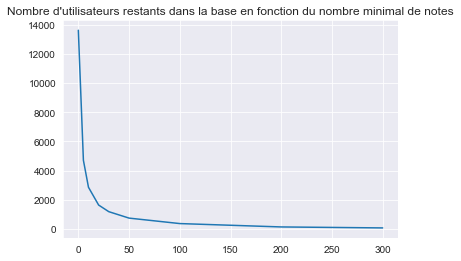

In [22]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_authors)
plt.title("Nombre d'utilisateurs restants dans la base en fonction du nombre minimal de notes")
plt.show()

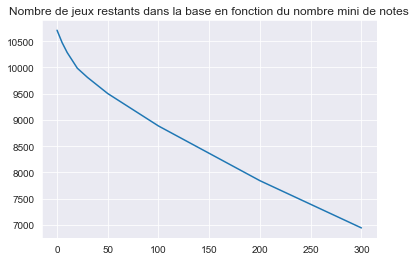

In [23]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_titles)
plt.title("Nombre de jeux restants dans la base en fonction du nombre mini de notes")
plt.show()

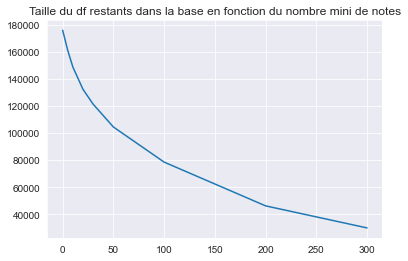

In [24]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=tailles_df)
plt.title("Taille du df restants dans la base en fonction du nombre mini de notes")
plt.show()

Nous avons decidé de prendre les trois cas suivants au vus des statisques après suppression de certains cas d'utilisateurs: 
- les utilisateurs ayant noté au moins 10 jeux
- les utilisateurs ayant noté au moins 50 jeux
- les utilisateurs ayant noté au moins 100 jeux
- les utilisateurs ayant noté au moins 200 jeux


## Déduction des quatres bases sur les quelles nous allons travailer et faire des comparaisons.

- df_avis_10 contient les données avec des utilisateurs ayant noté au moins 10 jeux
- df_avis_50 contient les données avec des utilisateurs ayant noté au moins 50 jeux
- df_avis_100 contient les données avec des utilisateurs ayant noté au moins 100 jeux
- df_avis_200 contient les données avec des utilisateurs ayant noté au moins 200 jeux


In [25]:
print(f"Taille de la base avant suppression:\n      --> {len(df_avis)}")

authors = df_avis['author'].value_counts()
authors_10  = authors[authors >= 10 ].index.to_list()
authors_50 = authors[authors >= 50].index.to_list()
authors_100 = authors[authors >= 100].index.to_list()
authors_200 = authors[authors >= 200].index.to_list()


df_avis_10  = df_avis[df_avis['author'].isin(authors_10)]
df_avis_50 = df_avis[df_avis['author'].isin(authors_50)]
df_avis_100 = df_avis[df_avis['author'].isin(authors_100)]
df_avis_200 = df_avis[df_avis['author'].isin(authors_200)]

print(f"Taille de la base après suppression des utilisateurs ayant noté moins d'un certain nombre de jeux:")
print(f"  10  --> {len(df_avis_10)}")
print(f"  50 --> {len(df_avis_50)}")
print(f"  100 --> {len(df_avis_100)}")
print(f"  200 --> {len(df_avis_200)}")


Taille de la base avant suppression:
      --> 176071
Taille de la base après suppression des utilisateurs ayant noté moins d'un certain nombre de jeux:
  10  --> 148961
  50 --> 104510
  100 --> 78541
  200 --> 46182


- La base df_avis_10  contient **148961** lignes pour **2849** utilisateurs et **10284** jeux.
- La base df_avis_50 contient **104510** lignes pour **734** utilisateurs et **9502** jeux.
- La base df_avis_100 contient **78541** lignes pour **359** utilisateurs et **8884** jeux.
- La base df_avis_200 contient **46182** lignes pour **128** utilisateurs et **7841** jeux.


## Jeux populaires

In [26]:
jeux_counts = df_avis.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 20 jeux les plus populaires dans la base:\n ",jeux_counts[:20])


Les 20 jeux les plus populaires dans la base:
  title
Shogun                                   172
Non Merci                                158
Boomerang                                156
Eclipse                                  155
Les mystères de Pékin                    155
Mare Nostrum                             153
Dune                                     153
Camelot                                  151
Poker                                    151
Intrigue                                 151
Samuraï                                  151
Guillotine                               151
Elysium                                  151
Not Alone                                150
Battlestar Galactica                     150
Clank!                                   150
Clans                                    150
Notre Dame - édition 10e anniversaire    150
Carcassonne                              150
Civilisation                             150
Name: note, dtype: int64


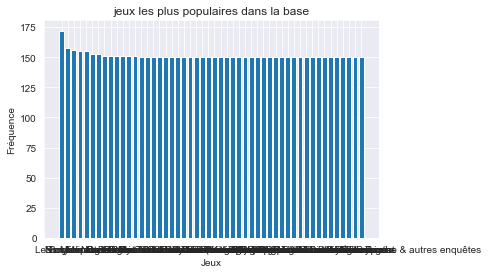

In [27]:
# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 10 jeux:
 title
Non Merci                    158
Shogun                       153
Camelot                      151
Uno Deluxe                   150
La Crique des Pirates        150
Gang Of Four                 150
Takenoko                     150
Marrakech - Astérix          150
La Traversée du Désert       150
Coloretto : 10 ans déjà      150
La Guerre des Moutons        150
Bang!                        150
Cluedo - Les bons voyages    150
L'Île interdite              150
Hanabi                       150
Seasons                      150
L'Âge de Pierre              150
Kuhhandel Master             150
Tigris & Euphrates           150
Service Compris !            150
Name: note, dtype: int64


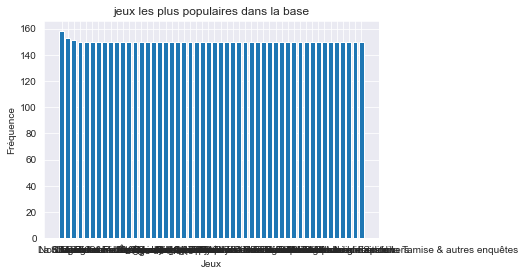

In [28]:
jeux_counts = df_avis_10.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 10 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 50 jeux:
 title
Les Chevaliers de la Table Ronde    150
L'Âge de Pierre                     150
La Guerre des Moutons               150
Jamaïca                             150
Time's Up !                         149
Dice Town                           149
Camelot                             149
Elixir                              149
Agricola                            149
Small World                         149
Pingouins                           148
Dominion                            148
Yspahan                             148
Mr. Jack - London                   148
Jungle Speed                        148
Citadelles : quatrième édition      148
Lost Cities - The Boardgame         147
Les Aventuriers du Rail             147
Caylus                              147
Bang!                               147
Name: note, dtype: int64


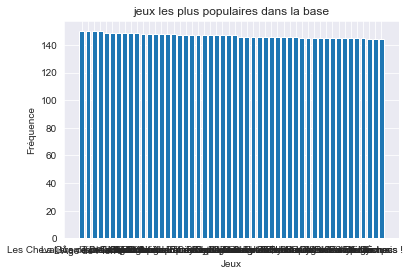

In [29]:
jeux_counts = df_avis_50.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 50 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 100 jeux:
 title
La Guerre des Moutons               146
Les Chevaliers de la Table Ronde    144
Small World                         144
Time's Up !                         143
Elixir                              142
L'Âge de Pierre                     141
Dominion                            141
Agricola                            139
Mr. Jack - London                   138
Citadelles : quatrième édition      138
Race for the Galaxy                 138
6 qui prend !                       138
Catan                               137
Caylus                              137
Les Aventuriers du Rail             137
Jamaïca                             137
Yspahan                             136
Lost Cities - The Boardgame         135
Formula D                           135
Bang!                               135
Name: note, dtype: int64


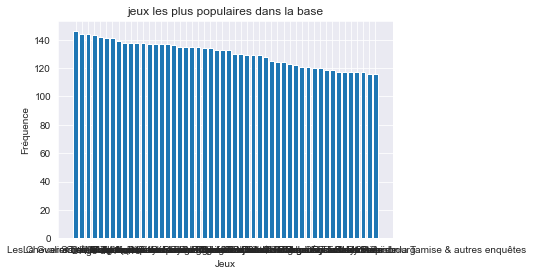

In [30]:
jeux_counts = df_avis_100.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 100 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 200 jeux:
 title
Les Aventuriers du Rail             82
Small World                         82
L'Âge de Pierre                     82
La Guerre des Moutons               82
Dominion                            79
Citadelles : quatrième édition      79
Les Chevaliers de la Table Ronde    78
6 qui prend !                       77
Jamaïca                             75
Caylus                              75
Agricola                            74
Time's Up !                         74
Coloretto : 10 ans déjà             73
Pandémie                            73
Carcassonne                         72
Jungle Speed                        72
Lost Cities - The Boardgame         71
Race for the Galaxy                 71
Dixit                               71
Pingouins                           69
Name: note, dtype: int64


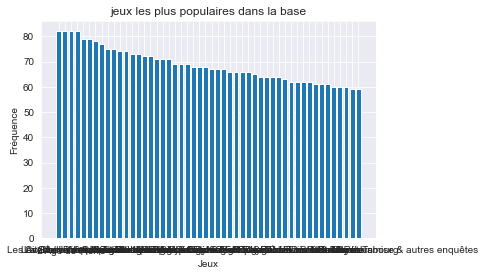

In [31]:
jeux_counts = df_avis_200.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 200 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

La distribution est un peu plate.
La liste des jeux les plus populaires n'est pas statique selon les bases considérées.

## Separation des données en plusieurs jeux de données pour la validation croisée(5 paquets de train/test).
Récupération de la liste de tous les jeux qui pourront être recommendés et des jeux les plus populaires.

In [32]:

from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True,random_state=0)

splits_10 = []
for train, test in kf.split(df_avis_10):
  X_train = df_avis_10.iloc[train].copy()
  X_test  = df_avis_10.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_10.append((X_train,X_test,(jeux_existants,jeux_populaires)))
    
splits_50 = []
for train, test in kf.split(df_avis_50):
  X_train = df_avis_50.iloc[train].copy()
  X_test  = df_avis_50.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_50.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_100 = []
for train, test in kf.split(df_avis_100):
  X_train = df_avis_100.iloc[train].copy()
  X_test  = df_avis_100.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_100.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_200 = []
for train, test in kf.split(df_avis_200):
  X_train = df_avis_200.iloc[train].copy()
  X_test  = df_avis_200.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_200.append((X_train,X_test,(jeux_existants,jeux_populaires)))



print(f"Validation croisée en {len(splits_10)} paquets")
    

Validation croisée en 5 paquets


## Nombre d'utilisateurs dans les paquets train et test

In [33]:
train_n_utils_10, train_n_jeux_10, l_jeux_populaires_10 = [],[],[]
train_n_utils_50, train_n_jeux_50, l_jeux_populaires_50 = [],[],[]
train_n_utils_100, train_n_jeux_100, l_jeux_populaires_100 = [],[],[]
train_n_utils_200, train_n_jeux_200, l_jeux_populaires_200 = [],[],[]


test_n_utils_10, test_n_jeux_10 = [],[]
test_n_utils_50, test_n_jeux_50 = [],[]
test_n_utils_100, test_n_jeux_100 = [],[]
test_n_utils_200, test_n_jeux_200 = [],[]


for ip in range(n_splits):
  X_train_10,X_test_10,je   = splits_10[ip]
  train_n_utils_10.append(X_train_10['author'].nunique())
  test_n_utils_10.append(X_test_10['author'].nunique())
  train_n_jeux_10.append(X_train_10['title'].nunique())
  test_n_jeux_10.append(X_test_10['title'].nunique())
  l_jeux_populaires_10.append(je[1])
    
  X_train_50,X_test_50,je = splits_50[ip]
  train_n_utils_50.append(X_train_50['author'].nunique())
  test_n_utils_50.append(X_test_50['author'].nunique())
  train_n_jeux_50.append(X_train_50['title'].nunique())
  test_n_jeux_50.append(X_test_50['title'].nunique())
  l_jeux_populaires_50.append(je[1])

  X_train_100,X_test_100,je = splits_100[ip]
  train_n_utils_100.append(X_train_100['author'].nunique())
  test_n_utils_100.append(X_test_100['author'].nunique())
  train_n_jeux_100.append(X_train_100['title'].nunique())
  test_n_jeux_100.append(X_test_100['title'].nunique())
  l_jeux_populaires_100.append(je[1])
  
  X_train_200,X_test_200,je = splits_200[ip]
  train_n_utils_200.append(X_train_200['author'].nunique())
  test_n_utils_200.append(X_test_200['author'].nunique())
  train_n_jeux_200.append(X_train_200['title'].nunique())
  test_n_jeux_200.append(X_test_200['title'].nunique())
  l_jeux_populaires_200.append(je[1])
  
  

In [34]:
print("Avec les utilisateurs ayant noté au moins 10 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_10)} std: {np.std(train_n_utils_10)}\n\t\t --> {train_n_utils_10}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_10)} std: {np.std(test_n_utils_10)}\n\t\t --> {test_n_utils_10}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_10)} std: {np.std(train_n_jeux_10)}\n\t\t --> {train_n_jeux_10}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_10)} std: {np.std(test_n_jeux_10)}\n\t\t --> {test_n_jeux_10}")
print(f"\tJeux populaires:")
for jp in l_jeux_populaires_10:
  print("\t\t",jp[:10])

Avec les utilisateurs ayant noté au moins 10 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 2849.0 std: 0.0
		 --> [2849, 2849, 2849, 2849, 2849]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 2776.4 std: 6.3118935352238
		 --> [2786, 2773, 2767, 2777, 2779]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 9679.6 std: 14.74584687293341
		 --> [9690, 9663, 9669, 9703, 9673]
	Nombre de jeux dans l'ensemble de test:
		moy: 6080.6 std: 15.05456741324705
		 --> [6081, 6061, 6084, 6071, 6106]
	Jeux populaires:
		 ['Pickomino', 'Elixir', 'Maka Bana', 'Sobek', 'Yspahan', 'Mr. Jack - London', 'Non Merci', 'Small World', 'Échecs', 'War of the ring : Anniversary Release']
		 ['La Havane', 'Maka Bana', 'King of Tokyo', 'Seasons', 'Abyss', 'Hanabi', '7 Wonders Duel', 'Zombicide', 'Service Compris !', 'Pique Plume']
		 ['Dungeon Lords', 'Agricola', 'Objets trouvés', 'Takenoko', 'Munchkin', 'The Island', 'Mr. Jack Pocket', "Can't Stop", 'Cl

In [35]:
print("Avec les utilisateurs ayant noté au moins 50 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_50)} std: {np.std(train_n_utils_50)}\n\t\t --> {train_n_utils_50}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_50)} std: {np.std(test_n_utils_50)}\n\t\t --> {test_n_utils_50}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_50)} std: {np.std(train_n_jeux_50)}\n\t\t --> {train_n_jeux_50}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_50)} std: {np.std(test_n_jeux_50)}\n\t\t --> {test_n_jeux_50}")
print(f"\tJeux populaires:")
for jp in l_jeux_populaires_50:
  print("\t\t",jp[:10])

Avec les utilisateurs ayant noté au moins 50 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 734.0 std: 0.0
		 --> [734, 734, 734, 734, 734]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 734.0 std: 0.0
		 --> [734, 734, 734, 734, 734]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 8887.4 std: 33.52372294361114
		 --> [8856, 8902, 8939, 8846, 8894]
	Nombre de jeux dans l'ensemble de test:
		moy: 5342.2 std: 32.41234332781263
		 --> [5372, 5377, 5288, 5346, 5328]
	Jeux populaires:
		 ["L'Âge de Pierre", 'Les Chevaliers de la Table Ronde', 'Scrabble', 'Lost Cities - The Boardgame', '6 qui prend !', 'Race for the Galaxy', 'Lords of Xidit', 'Roborally', 'Jamaïca', 'Cyclades']
		 ['Les Chevaliers de la Table Ronde', 'Mr. Jack - London', 'Jamaïca', 'Elixir', 'Il était une fois', 'Takenoko', 'Dice Town', 'Splendor', 'Lords of Xidit', 'Saboteur']
		 ['Yspahan', 'Sherlock Holmes Détective Conseil : les meurtres de la Tamise & autres 

In [36]:
print("Avec les utilisateurs ayant noté au moins 100 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_100)} std: {np.std(train_n_utils_100)}\n\t\t --> {train_n_utils_100}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_100)} std: {np.std(test_n_utils_100)}\n\t\t --> {test_n_utils_100}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_100)} std: {np.std(train_n_jeux_100)}\n\t\t --> {train_n_jeux_100}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_100)} std: {np.std(test_n_jeux_100)}\n\t\t --> {test_n_jeux_100}")
print(f"\tJeux populaires:")
for jp in l_jeux_populaires_100:
  print("\t\t",jp[:10])

Avec les utilisateurs ayant noté au moins 100 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 359.0 std: 0.0
		 --> [359, 359, 359, 359, 359]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 359.0 std: 0.0
		 --> [359, 359, 359, 359, 359]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 8261.0 std: 7.26636084983398
		 --> [8258, 8270, 8250, 8259, 8268]
	Nombre de jeux dans l'ensemble de test:
		moy: 4747.4 std: 33.77928359216637
		 --> [4768, 4680, 4761, 4763, 4765]
	Jeux populaires:
		 ['La Guerre des Moutons', 'Les Aventuriers du Rail', 'Les Chevaliers de la Table Ronde', "L'Âge de Pierre", '6 qui prend !', 'Elixir', 'Citadelles : quatrième édition', 'Small World', 'Mr. Jack - London', 'Dominion']
		 ['Small World', 'Dominion', 'Elixir', "L'Âge de Pierre", 'Yspahan', "Time's Up !", 'Caylus', 'Jamaïca', 'Agricola', 'La Guerre des Moutons']
		 ['6 qui prend !', 'Agricola', 'Caylus', 'Small World', 'Camelot', 'Les Chevaliers de l

In [37]:
print("Avec les utilisateurs ayant noté au moins 200 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_200)} std: {np.std(train_n_utils_200)}\n\t\t --> {train_n_utils_200}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_200)} std: {np.std(test_n_utils_200)}\n\t\t --> {test_n_utils_200}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_200)} std: {np.std(train_n_jeux_200)}\n\t\t --> {train_n_jeux_200}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_200)} std: {np.std(test_n_jeux_200)}\n\t\t --> {test_n_jeux_200}")
print(f"\tJeux populaires:")
for jp in l_jeux_populaires_200:
  print("\t\t",jp[:10])

Avec les utilisateurs ayant noté au moins 200 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 128.0 std: 0.0
		 --> [128, 128, 128, 128, 128]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 128.0 std: 0.0
		 --> [128, 128, 128, 128, 128]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 7230.8 std: 8.541662601625049
		 --> [7231, 7223, 7225, 7228, 7247]
	Nombre de jeux dans l'ensemble de test:
		moy: 3854.6 std: 29.38434957592221
		 --> [3862, 3868, 3807, 3895, 3841]
	Jeux populaires:
		 ['La Guerre des Moutons', 'Dominion', 'Les Chevaliers de la Table Ronde', "L'Âge de Pierre", 'Les Aventuriers du Rail', 'Citadelles : quatrième édition', 'Small World', 'Lost Cities - The Boardgame', 'Agricola', "Time's Up !"]
		 ['La Guerre des Moutons', "Time's Up !", 'Les Aventuriers du Rail', "L'Âge de Pierre", 'Citadelles : quatrième édition', 'Jungle Speed', 'Dominion', 'Agricola', 'Caylus', 'Small World']
		 ["L'Âge de Pierre", 'Les Avent

Cas où les utilisateurs ont noté plus de 10 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **2849**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **2842.8**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **2385.2**

Cas où les utilisateurs ont noté plus de 50 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **734**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **734.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **734.0**

Cas où les utilisateurs ont noté plus de 100 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **359**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **359.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **358.0**

Cas où les utilisateurs ont noté plus de 200 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **128**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **128.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **128.0**



`Consernant les jeux les plus populaires la liste change considérablement`

## Mean Reciprocal Rank 

$$ MRR = \frac{1}{|Q|}\sum^{|Q|}_{i=1}\frac{1}{\text{rank}_i} $$

In [38]:
def rr(list_items):
    relevant_indexes = np.asarray(list_items).nonzero()[0]
    
    if len(relevant_indexes) > 0:
        
        #NOTE:
        # relevant_indexes[0] <= Contains the index of the 1st relevant item ([0,0,1] => 2)
        
        return 1 / (relevant_indexes[0] + 1)
    else:
        return 0

def mrr(list_list_items):
    rr_list = [rr(list_items) for list_items in list_list_items]
    return np.mean(rr_list)

## Discounted Cumulative Gain

$$DCG_p = \sum^p_{i=1}\frac{rel_i}{\log_2{(i+1)}} = rel_1 + \sum^p_{i=2}\frac{rel_i}{\log_2{(i+1)}}$$

In [39]:
def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return r[0] +  np.sum(r[1:] / np.log2(np.arange(3, r.size + 2)))
        
    return 0.

$$ nDCG_p = \frac{DCG_p}{IDCG_p} $$


$$ IDCG_p = max(DCG_p) $$

In [40]:
def ndcg_at_k(r, k):
    """
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
    """
    dcg_max =  np.max(dcg_at_k(sorted(r)[::-1], k))
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k)/dcg_max

- `already_seen`: les jeux que l'utilisateur a déjà noté. Pour ne pas les recommender encore.
- `ground_truth`: Les jeux que l'utilisateur est suseptible d'aimer (note >= 10). C'est notre ground truth l'évaluer nos predictions.

In [41]:
already_seen_10 = []
already_seen_50 = []
already_seen_100 = []
already_seen_200 = []


ground_truth_10 = []
ground_truth_50 = []
ground_truth_100 = []
ground_truth_200 = []

ground_truth_n7_10 = []
ground_truth_n7_50 = []
ground_truth_n7_100 = []
ground_truth_n7_200 = []


for ip in range(n_splits):
    # Pour le cas des utilisateurs qui ont noté au moins 10 jeux
    X_train_10,X_test_10,je = splits_10[ip]
    already_seen = (
        X_train_10
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_10[X_test_10.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_10[X_test_10.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_10.append(already_seen)
    ground_truth_10.append(ground_truth)
    ground_truth_n7_10.append(ground_truth_n7)
    
    # Pour le cas des utilisateurs qui ont noté au moins 50 jeux
    X_train_50,X_test_50,je = splits_50[ip]
    already_seen = (
        X_train_50
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_50[X_test_50.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_50[X_test_50.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_50.append(already_seen)
    ground_truth_50.append(ground_truth)
    ground_truth_n7_50.append(ground_truth_n7)
    
    
    
    # Pour le cas des utilisateurs qui ont noté au moins 100 jeux
    X_train_100,X_test_100,je = splits_100[ip]
    already_seen = (
        X_train_100
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_100[X_test_100.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_100[X_test_100.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_100.append(already_seen)
    ground_truth_100.append(ground_truth)
    ground_truth_n7_100.append(ground_truth_n7)
    
    
    
    # Pour le cas des utilisateurs qui ont noté au moins 200 jeux
    X_train_200,X_test_200,je = splits_200[ip]
    already_seen = (
        X_train_200
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_200[X_test_200.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_200[X_test_200.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_200.append(already_seen)
    ground_truth_200.append(ground_truth)
    ground_truth_n7_200.append(ground_truth_n7)
    
    
    
   

#  Surprise SVD recommender

In [42]:
from surprise import Dataset

datas_10 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_10]
models_10 = [SVD() for i in range(len(splits_10))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_10,datas_10)]

datas_50 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_50]
models_50 = [SVD() for i in range(len(splits_50))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_50,datas_50)]

datas_100 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_100]
models_100 = [SVD() for i in range(len(splits_100))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_100,datas_100)]


datas_200 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_200]
models_200 = [SVD() for i in range(len(splits_200))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_200,datas_200)]



In [43]:
model_et = None
def svd_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    prediction = model_et.predict(user,item)
    
    return prediction.est

for ip in range(n_splits):
    X_train,X_test,je = splits_10[ip]
    model_et = models_10[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 
    

for ip in range(n_splits):
    X_train,X_test,je = splits_50[ip]
    model_et = models_50[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

for ip in range(n_splits):
    X_train,X_test,je = splits_100[ip]
    model_et = models_100[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

for ip in range(n_splits):
    X_train,X_test,je = splits_200[ip]
    model_et = models_200[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 


In [44]:
mses_10,maes_10 = [],[]
mses_50,maes_50 = [],[]
mses_100,maes_100 = [],[]
mses_200,maes_200 = [],[]


for ip in range(n_splits):
  X_train,X_test,je = splits_10[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_10.append(mse)
  maes_10.append(mae)

  X_train,X_test,je = splits_50[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_50.append(mse)
  maes_50.append(mae)
  
  X_train,X_test,je = splits_100[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_100.append(mse)
  maes_100.append(mae)
  
  X_train,X_test,je = splits_200[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_200.append(mse)
  maes_200.append(mae)
  
  

print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  MSE:\n    moy {np.mean(mses_10)}\n    std {np.std(mses_10)}\n    {mses_10}")
print(f"  MAE:\n    moy {np.mean(maes_10)}\n    std {np.std(maes_10)}\n    {maes_10}")
print("Avec les utilisateurs ayant noté au moins 50 jeux")
print(f"  MSE:\n    moy {np.mean(mses_50)}\n    std {np.std(mses_50)}\n    {mses_50}")
print(f"  MAE:\n    moy {np.mean(maes_50)}\n    std {np.std(maes_50)}\n    {maes_50}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  MSE:\n    moy {np.mean(mses_100)}\n    std {np.std(mses_100)}\n    {mses_100}")
print(f"  MAE:\n    moy {np.mean(maes_100)}\n    std {np.std(maes_100)}\n    {maes_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  MSE:\n    moy {np.mean(mses_200)}\n    std {np.std(mses_200)}\n    {mses_200}")
print(f"  MAE:\n    moy {np.mean(maes_200)}\n    std {np.std(maes_200)}\n    {maes_200}")


Avec les utilisateurs ayant noté au moins 10 jeux
  MSE:
    moy 3.609522518992997
    std 0.02525689971574968
    [3.6473035592517755, 3.5743525982343756, 3.5900955151619143, 3.6161375408750063, 3.619723381441911]
  MAE:
    moy 1.4633909198978023
    std 0.006253627067319426
    [1.474355999663996, 1.4576918698149413, 1.4570968788827832, 1.4650633200154233, 1.4627465311118681]
Avec les utilisateurs ayant noté au moins 50 jeux
  MSE:
    moy 3.592101332775209
    std 0.03609183139827148
    [3.65102205002463, 3.5579875338890967, 3.5527952403476077, 3.5886828050119144, 3.6100190346027983]
  MAE:
    moy 1.469245559568356
    std 0.004364269538539108
    [1.4710724785549734, 1.4651609998576471, 1.464830355500225, 1.4684920231482137, 1.4766719407807212]
Avec les utilisateurs ayant noté au moins 100 jeux
  MSE:
    moy 3.5907102036665215
    std 0.0448678880079326
    [3.6013806736122396, 3.541470522590856, 3.6663869683576498, 3.5957336804410196, 3.548579173330843]
  MAE:
    moy 1.474648

In [45]:
def model_rating_pred(model,user,item):
    prediction = model.predict(user,item)
    return prediction.est

###  the relevance list for our MRR function

In [46]:
svd_mrrs_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_10[ip]
    jeux_existants = splits_10[ip][2][0]
    model = models_10[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_10.append(svd_mrr)

In [47]:
svd_mrrs_50 = []

for ip in range(n_splits):
    already_seen = already_seen_50[ip]
    ground_truth = ground_truth_50[ip]
    jeux_existants = splits_50[ip][2][0]
    model = models_50[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_50.append(svd_mrr)

In [48]:
svd_mrrs_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_100[ip]
    jeux_existants = splits_100[ip][2][0]
    model = models_100[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_100.append(svd_mrr)

In [49]:
svd_mrrs_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_200[ip]
    jeux_existants = splits_200[ip][2][0]
    model = models_200[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_200.append(svd_mrr)

In [50]:
rels_10,rels_50, rels_100,rels_200 = [],[],[],[]
jeux_existants_10  = [len(je) for X_train,X_test,(je,jp) in splits_10]
jeux_existants_50 = [len(je) for X_train,X_test,(je,jp) in splits_50]
jeux_existants_100 = [len(je) for X_train,X_test,(je,jp) in splits_100]
jeux_existants_200 = [len(je) for X_train,X_test,(je,jp) in splits_200]


for i in range(len(svd_mrrs_10)):
  svd_mrr = svd_mrrs_10[i]
  rels_10.append(int(round(1/svd_mrr,0)))
    
  svd_mrr = svd_mrrs_50[i]
  rels_50.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_100[i]
  rels_100.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_200[i]
  rels_200.append(int(round(1/svd_mrr,0)))
  
  

# f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(rels_10)}\n  std {np.std(rels_10)} sur {np.mean(jeux_existants_10)}\n  {rels_10}")
print("Avec les utilisateurs ayant noté au moins 50 jeux")
print(f"  moy {np.mean(rels_50)}\n  std {np.std(rels_50)} sur {np.mean(jeux_existants_50)}\n  {rels_50}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(rels_100)}\n  std {np.std(rels_100)} sur {np.mean(jeux_existants_100)}\n  {rels_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(rels_200)}\n  std {np.std(rels_200)} sur {np.mean(jeux_existants_200)}\n  {rels_200}")


Avec les utilisateurs ayant noté au moins 10 jeux
  moy 33.6
  std 2.4979991993593593 sur 9679.6
  [35, 29, 33, 35, 36]
Avec les utilisateurs ayant noté au moins 50 jeux
  moy 15.8
  std 0.7483314773547882 sur 8887.4
  [15, 16, 17, 15, 16]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 10.0
  std 1.0954451150103321 sur 8261.0
  [9, 9, 12, 10, 10]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 6.8
  std 0.7483314773547882 sur 7230.8
  [6, 7, 6, 7, 8]


- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **34.8** sur **9679.6**.

- En éliminant les utilisateurs ayant noter moins de **50** jeux nous avons une mrr de **16.6** sur **8887.4**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **10.6** sur **8261**. </br>

- En éliminant les utilisateurs ayant noter moins de **200** jeux nous avons une mrr de **7.2** sur **7230.8**. </br>




###  the relevance list for our MRR function avec note>=7

In [51]:
svd_mrrs_n7_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_n7_10[ip]
    jeux_existants = splits_10[ip][2][0]
    model = models_10[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_n7_10.append(svd_mrr)

In [52]:
svd_mrrs_n7_50 = []

for ip in range(n_splits):
    already_seen = already_seen_50[ip]
    ground_truth = ground_truth_n7_50[ip]
    jeux_existants = splits_50[ip][2][0]
    model = models_50[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_n7_50.append(svd_mrr)

In [53]:
svd_mrrs_n7_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_n7_100[ip]
    jeux_existants = splits_100[ip][2][0]
    model = models_100[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_n7_100.append(svd_mrr)

In [54]:
svd_mrrs_n7_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_n7_200[ip]
    jeux_existants = splits_200[ip][2][0]
    model = models_200[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_n7_200.append(svd_mrr)

In [55]:
rels_10, rels_50,rels_100,rels_200 = [],[],[],[]

for i in range(len(svd_mrrs_n7_10)):
  svd_mrr = svd_mrrs_n7_10[i]
  rels_10.append(int(round(1/svd_mrr,0)))
    
  svd_mrr = svd_mrrs_n7_50[i]
  rels_50.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_n7_100[i]
  rels_100.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_n7_200[i]
  rels_200.append(int(round(1/svd_mrr,0)))
  
  

# f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(rels_10)}\n  std {np.std(rels_10)} sur {np.mean(jeux_existants_10)}\n  {rels_10}")
print("Avec les utilisateurs ayant noté au moins 50 jeux")
print(f"  moy {np.mean(rels_50)}\n  std {np.std(rels_50)} sur {np.mean(jeux_existants_50)}\n  {rels_50}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(rels_100)}\n  std {np.std(rels_100)} sur {np.mean(jeux_existants_100)}\n  {rels_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(rels_200)}\n  std {np.std(rels_200)} sur {np.mean(jeux_existants_200)}\n  {rels_200}")


Avec les utilisateurs ayant noté au moins 10 jeux
  moy 29.2
  std 1.7204650534085253 sur 9679.6
  [30, 29, 27, 28, 32]
Avec les utilisateurs ayant noté au moins 50 jeux
  moy 10.8
  std 0.39999999999999997 sur 8887.4
  [10, 11, 11, 11, 11]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 6.4
  std 0.48989794855663565 sur 8261.0
  [6, 6, 6, 7, 7]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 4.2
  std 0.39999999999999997 sur 7230.8
  [4, 4, 4, 5, 4]


En considérant que si un utilisateur met une note >= 7 il aime le film les performances de la recommendations sont nettement améliorées, pas beaucoup mais c'est quand même significatif.

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **30.0** sur **9679.6**.

- En éliminant les utilisateurs ayant noter moins de **50** jeux nous avons une mrr de **10.8** sur **8887.4**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **6.6** sur **8261**. </br>

- En éliminant les utilisateurs ayant noter moins de **200** jeux nous avons une mrr de **4.4** sur **7230.8**. </br>



# Implicit baseline: popular items

### popular recommendation relevance list per user

In [56]:
list_of_rels_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_10[ip]
    jeux_populaires = splits_10[ip][2][1]
    model = models_10[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_10.append(list_of_rel)

In [57]:
list_of_rels_50 = []

for ip in range(n_splits):
    already_seen = already_seen_50[ip]
    ground_truth = ground_truth_50[ip]
    jeux_populaires = splits_50[ip][2][1]
    model = models_50[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_50.append(list_of_rel)

In [58]:
list_of_rels_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_100[ip]
    jeux_populaires = splits_100[ip][2][1]
    model = models_100[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_100.append(list_of_rel)

In [59]:
list_of_rels_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_200[ip]
    jeux_populaires = splits_200[ip][2][1]
    model = models_200[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_200.append(list_of_rel)

In [60]:
pop_mrrs_10, pop_mrrs_50, pop_mrrs_100,pop_mrrs_200 = [],[],[],[]
for i in range(len(list_of_rels_10)):
  list_of_rel = list_of_rels_10[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_10.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_50[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_50.append(int(round(1/pop_mrr,0)))
  
  list_of_rel = list_of_rels_100[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_100.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_200[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_200.append(int(round(1/pop_mrr,0)))

  

# f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(pop_mrrs_10)}\n  std {np.std(pop_mrrs_10)} sur {np.mean(jeux_existants_10)}\n  {pop_mrrs_10}")
print("Avec les utilisateurs ayant noté au moins 50 jeux")
print(f"  moy {np.mean(pop_mrrs_50)}\n  std {np.std(pop_mrrs_50)} sur {np.mean(jeux_existants_50)}\n  {pop_mrrs_50}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(pop_mrrs_100)}\n  std {np.std(pop_mrrs_100)} sur {np.mean(jeux_existants_100)}\n  {pop_mrrs_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(pop_mrrs_200)}\n  std {np.std(pop_mrrs_200)} sur {np.mean(jeux_existants_200)}\n  {pop_mrrs_200}")


Avec les utilisateurs ayant noté au moins 10 jeux
  moy 51.6
  std 4.127953488110059 sur 9679.6
  [58, 49, 46, 51, 54]
Avec les utilisateurs ayant noté au moins 50 jeux
  moy 18.2
  std 1.9390719429665315 sur 8887.4
  [17, 20, 19, 20, 15]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 8.0
  std 1.0954451150103321 sur 8261.0
  [10, 7, 7, 8, 8]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 5.0
  std 0.6324555320336759 sur 7230.8
  [5, 5, 6, 5, 4]


- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **51.6** en moyenne sur **9679.6**.

- En éliminant les utilisateurs ayant noter moins de **50** jeux nous avons une mrr de **18.2** en moyenne sur **8887.4**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **8.0** en moyenne sur **8261.0**. </br>

- En éliminant les utilisateurs ayant noter moins de **200** jeux nous avons une mrr de **5.0** en moyenne sur **7230.8**. </br>



### popular recommendation relevance list per user avec note>=7

In [61]:
list_of_rels_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_n7_10[ip]
    jeux_populaires = splits_10[ip][2][1]
    model = models_10[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_10.append(list_of_rel)

In [62]:
list_of_rels_50 = []

for ip in range(n_splits):
    already_seen = already_seen_50[ip]
    ground_truth = ground_truth_n7_50[ip]
    jeux_populaires = splits_50[ip][2][1]
    model = models_50[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_50.append(list_of_rel)

In [63]:
list_of_rels_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_n7_100[ip]
    jeux_populaires = splits_100[ip][2][1]
    model = models_100[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_100.append(list_of_rel)

In [64]:
list_of_rels_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_n7_200[ip]
    jeux_populaires = splits_200[ip][2][1]
    model = models_200[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_200.append(list_of_rel)

In [65]:
pop_mrrs_10, pop_mrrs_50, pop_mrrs_100,pop_mrrs_200 = [],[],[],[]
for i in range(len(list_of_rels_10)):
  list_of_rel = list_of_rels_10[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_10.append(int(round(1/pop_mrr,0)))


  list_of_rel = list_of_rels_50[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_50.append(int(round(1/pop_mrr,0)))
    
  list_of_rel = list_of_rels_100[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_100.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_200[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_200.append(int(round(1/pop_mrr,0)))


# f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(pop_mrrs_10)}\n  std {np.std(pop_mrrs_10)} sur {np.mean(jeux_existants_10)}\n  {pop_mrrs_10}")
print("Avec les utilisateurs ayant noté au moins 50 jeux")
print(f"  moy {np.mean(pop_mrrs_50)}\n  std {np.std(pop_mrrs_50)} sur {np.mean(jeux_existants_50)}\n  {pop_mrrs_50}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(pop_mrrs_100)}\n  std {np.std(pop_mrrs_100)} sur {np.mean(jeux_existants_100)}\n  {pop_mrrs_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(pop_mrrs_200)}\n  std {np.std(pop_mrrs_200)} sur {np.mean(jeux_existants_200)}\n  {pop_mrrs_200}")


Avec les utilisateurs ayant noté au moins 10 jeux
  moy 35.4
  std 0.4898979485566356 sur 9679.6
  [36, 36, 35, 35, 35]
Avec les utilisateurs ayant noté au moins 50 jeux
  moy 10.2
  std 0.9797958971132712 sur 8887.4
  [10, 10, 10, 12, 9]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 4.6
  std 0.48989794855663565 sur 8261.0
  [5, 4, 4, 5, 5]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 3.0
  std 0.0 sur 7230.8
  [3, 3, 3, 3, 3]


En considérant que si un utilisateur met une note >= 7 il aime le film les performances de la recommendations sont nettement améliorées, pas beaucoup mais c'est quand même significatif.

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **35.4** en moyenne sur **9679.6**.

- En éliminant les utilisateurs ayant noter moins de **50** jeux nous avons une mrr de **10.2** en moyenne sur **8887.4**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **4.6** en moyenne sur **8261.0**. </br>

- En éliminant les utilisateurs ayant noter moins de **200** jeux nous avons une mrr de **3.0** en moyenne sur **7230.8**. </br>
